# Задача 9. Hand-crafted graph features

## Задача

- [x] Найти или сгенерировать набор данных для бинарной классификации графов.
- [x] Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`, которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать `nx.shortest_path_length(G)`
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
  - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- [x] Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- [x] (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [98]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.generators import random_unlabeled_tree, random_lobster
import torch
import itertools
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import tqdm

# Набор данных

In [99]:
def graph_to_edge_list(G: nx.Graph):
    edge_list = list(G.edges())

    return edge_list


def edges_to_tensor(edge_list):
    edge_index = torch.tensor(edge_list, dtype=torch.long).permute((1, 0))

    return edge_index


def generate_good_lobster():
    while True:
        lobster = random_lobster(10, 0.8, 0.8)

        if len(lobster.nodes) == 40:
            return lobster


# 0 - lobster tree
# 1 - default tree


def create_dataset(size):
    lobster_graphs = list(itertools.repeat(generate_good_lobster(), size // 2))
    y1 = [0] * len(lobster_graphs)

    default_tree_graphs = list(itertools.repeat(random_unlabeled_tree(40), size // 2))
    y2 = [1] * len(default_tree_graphs)

    graphs = list(itertools.chain(lobster_graphs, default_tree_graphs))
    y = list(itertools.chain(y1, y2))

    return graphs, y

40 40


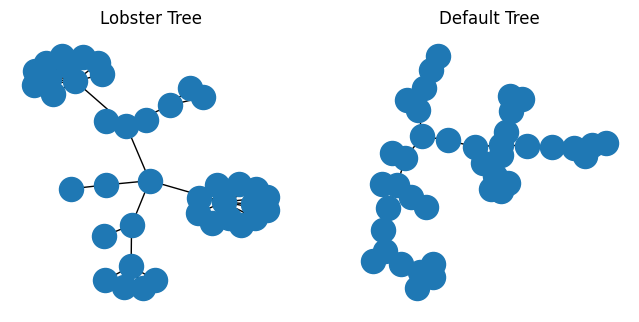

In [100]:
graphs, y = create_dataset(1000)

train_graphs, test_graphs, y_train, y_test = train_test_split(
    graphs, y, test_size=0.5, stratify=y
)

fig = plt.figure(figsize=(8, 8))

lobster_tree = train_graphs[y_train.index(0)]
default_tree = train_graphs[y_train.index(1)]

print(len(lobster_tree.nodes), len(default_tree.nodes))

ax1 = fig.add_subplot(2, 2, 1)
nx.draw(lobster_tree, ax=ax1)
ax1.set_title("Lobster Tree")

ax2 = fig.add_subplot(2, 2, 2)
nx.draw(default_tree, ax=ax2)
ax2.set_title("Default Tree")

plt.show()

# Shortest Path Kernel

In [101]:
def shortest_path_kernel(train_graphs, test_graphs, max_paths=5, n_samples=10):
    phi_train = np.zeros((len(train_graphs), max_paths))
    phi_test = np.zeros((len(test_graphs), max_paths))

    for i, graph in enumerate(train_graphs):
        for j in range(n_samples):
            pair = np.random.choice(graph.nodes(), 2)
            source, target = pair[0], pair[1]

            path_length = nx.shortest_path_length(graph, source, target)
            path_length = min(path_length, max_paths - 1)

            phi_train[i][path_length] += 1

    for i, graph in enumerate(test_graphs):
        for j in range(n_samples):
            pair = np.random.choice(graph.nodes(), 2)
            source, target = pair[0], pair[1]

            path_length = nx.shortest_path_length(graph, source, target)
            path_length = min(path_length, max_paths - 1)

            phi_test[i][path_length] += 1

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test


# Обучение

In [102]:
K_train_gk, K_test_gk = shortest_path_kernel(train_graphs, test_graphs)

In [103]:
model = SVC(kernel="precomputed", random_state=42)
model.fit(K_train_gk, y_train)
y_pred = model.predict(K_test_gk)
print("Accuracy for Shortest Path Kernel", accuracy_score(y_test, y_pred))

Accuracy for Shortest Path Kernel 0.792


## Подбор гиперпараметров

In [104]:
MAX_PATH_LENGTHS = [1, 5, 10, 15, 20, 30]
SAMPLES_COUNT = [1, 10, 20, 30, 40, 50]

path_accuracy = []
samples_accuracy = []


for max_path in tqdm.tqdm(MAX_PATH_LENGTHS):
    K_train_gk, K_test_gk = shortest_path_kernel(
        train_graphs, test_graphs, max_paths=max_path
    )
    model = SVC(kernel="precomputed", random_state=42)
    model.fit(K_train_gk, y_train)
    y_pred = model.predict(K_test_gk)
    path_accuracy.append(accuracy_score(y_test, y_pred))

for samples_count in tqdm.tqdm(SAMPLES_COUNT):
    K_train_gk, K_test_gk = shortest_path_kernel(
        train_graphs, test_graphs, n_samples=samples_count
    )
    model = SVC(kernel="precomputed", random_state=42)
    model.fit(K_train_gk, y_train)
    y_pred = model.predict(K_test_gk)
    samples_accuracy.append(accuracy_score(y_test, y_pred))

100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


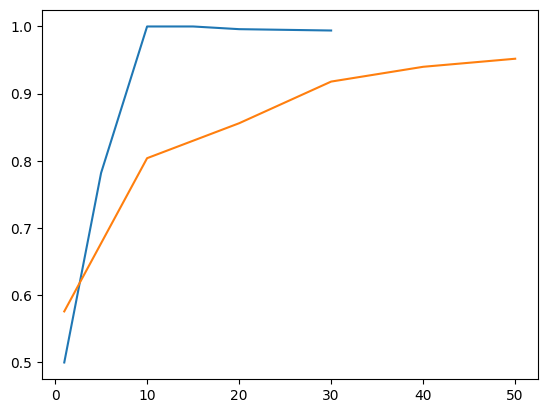

In [105]:
plt.plot(MAX_PATH_LENGTHS, path_accuracy)
plt.plot(SAMPLES_COUNT, samples_accuracy)
plt.show()

Из графика выше можно сделать вывод, что значение *максимального количества путей* (отслеживаемого в функции построения ядра), больше влияет на обучаемость модели, чем *количество измерений количества путей*.

Также, удалось достичь достаточно высокого показателя accuracy на большой (50%) тестовой выборке. Можно сделать предположение, что отличить Lobster Graph от обычного дерева достаточно просто...

# WL-Kernel

In [110]:
def wl_kernel_helper(graph: nx.Graph, iterations=1, limit=100):
    for node in graph.nodes:
        graph.nodes[node]["color"] = "1"

    hash_table = {}
    max_color = 2

    for i in range(iterations):
        if i > 0:
            for node in graph.nodes:
                value = f"{graph.nodes[node]['color']},{graph.nodes[node]['neighbor_colors']}"
                graph.nodes[node]["neighbor_colors"] = ""
                graph.nodes[node]["color"] = str(hash_table[value])

        for node in graph.nodes:
            graph.nodes[node]["neighbor_colors"] = ""

            for neighbor in nx.neighbors(graph, node):
                graph.nodes[node]["neighbor_colors"] += graph.nodes[neighbor]["color"]

        for node in graph.nodes:
            value = (
                f"{graph.nodes[node]['color']},{graph.nodes[node]['neighbor_colors']}"
            )

            if value not in hash_table:
                hash_table[value] = max_color
                max_color += 1

    phi = np.zeros(limit)

    for node in graph.nodes:
        value = f"{graph.nodes[node]['color']},{graph.nodes[node]['neighbor_colors']}"
        color = min(hash_table[value], limit - 1)

        phi[color] += 1

    return phi


def wl_kernel(train_graphs, test_graphs, iterations=1, limit=100):
    phi_train = np.zeros((len(train_graphs), limit))
    phi_test = np.zeros((len(test_graphs), limit))

    for i, graph in enumerate(train_graphs):
        phi_train[i] = wl_kernel_helper(graph, iterations, limit)

    for i, graph in enumerate(test_graphs):
        phi_test[i] = wl_kernel_helper(graph, iterations, limit)

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

In [ ]:
K_train_gk, K_test_gk = wl_kernel(train_graphs, test_graphs, iterations=1, limit=50)
model = SVC(kernel="precomputed", random_state=42)

model.fit(K_train_gk, y_train)
y_pred = model.predict(K_test_gk)

print(accuracy_score(y_test, y_pred))

1.0
